Data Exploration and Failure Prediction of SSR-Mining Trucks

Team Members: Cody Griffith, Howell Tan, Mirazami Saeed, Shams Elnawawi, Nicholas Dembek, Michelle, Sunny, Mohammed Wali Ullah, Sohrab

Mentor: Junbo, Vien 

Introduction:

    SSR relies heavily on hauling trucks to transport material. This can be up to 200,000 tonnes per day making them integral to operations at a mine. Breakdowns of these trucks can be costly for example: last year, 41 % of the Marigold total direct cost went towards maintenance. Breakdowns also jeopardize the efficiency of operations at a mine. Therefore, decreasing the unexpected maintenance events associated with a truck would financially and operationally benefit the company as maintenance before a breakdown would be a lower cost preventative measure. 


The Goal of this Project:
	
    Predicting unscheduled component failures of haul trucks before they happen based on alarm data streamed from truck sensors.


The Data:

	The cell below shows where the data comes from and what information each system collects. The end result was the collection of 50GB of data for the Hitachi EH500 ACII fleet. 


    The dataset covers 12 months (May 2017 – Apr 2018) worth of equipment identifiers, time profiles, production, performance, alarms and work order history.  The 3 systems used are:

    Dispatch: This dataset contains haul truck production summary (Equipment IDs, Tons moved, distance traveled and cycle time) and equipment time profile (operative, delays, downtime, idle time, and standby) along with downtime reasons and comments 

    Minecare: This data set contains haul truck sensors data, alarms and alerts history

    eMaint: Maintenance Work order history which includes work order time, downtime type, work type, equipment and components and parts usage

    The Cell below shows the relationship between all the data tables collected from the systems above.

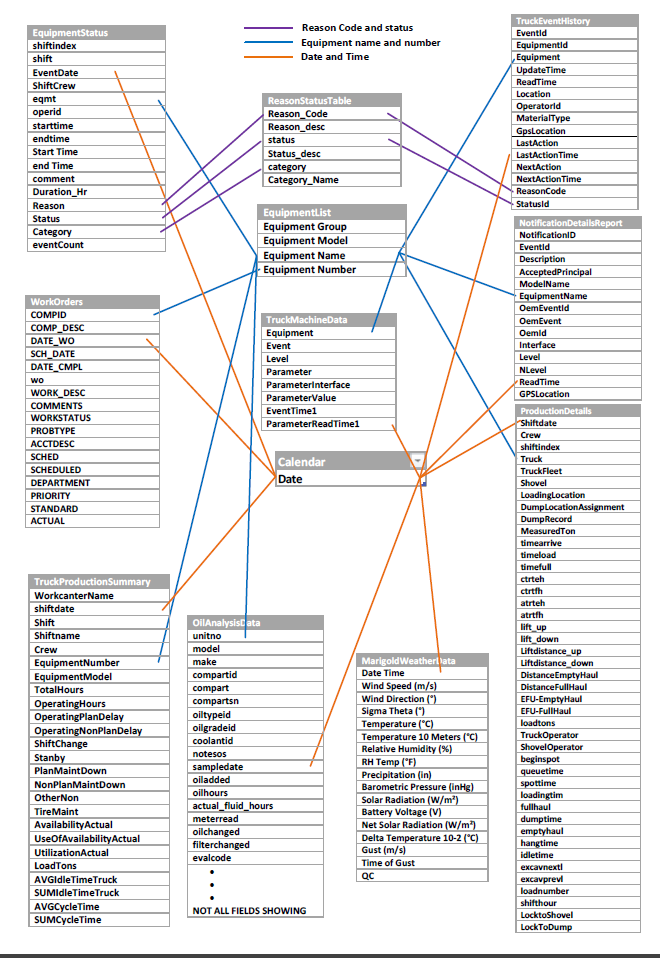

Initial Data Exploration:

	Because of the large amount of data we began by looking at certain tables to see if anything could be learned before developing a model. We focused on TruckMachineData,WorkOrders, and NotificationDetailsReport tables. 
    
	Below begins the summation of failures and alarms associated with all trucks. An alarm is raised by a sensor measuring a parameter of a truck (tire pressure, coolant temperature, etc) associated with some mechanical part. When this alarm is raised, the parameter measurement is recorded along with its alarm level. An alarm has three levels: 1,2,3. In the case, alarm level 1 is critical and is the most dangerous alarm. 
  

In [ ]:
#importing necessary packages
import numpy as np
import pandas as pd
import folium
import datetime
import matplotlib.pyplot as plt
import matplotlib
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from folium import plugins

In [ ]:
NDR = pd.read_csv('/Maintenance/NotificationDetailsReport.csv')
equipValues = NDR['Level'] # filtering Level
equipName = NDR['EquipmentName'] # filtering Truck Names
myDict = set(equipName) # finding the name of Trucks
myDictList = list(myDict) # set to list
Truck = [0]*len(myDictList) # Truck is a list of number 1 alarms
for i in range (len(equipValues)):
    if equipValues[i] == 1:
        current_Truck = myDictList.index(equipName[i])
        Truck[current_Truck] += 1

minCritical = Truck.index(min(Truck))
barlist = plt.bar(myDictList, Truck)
barlist[minCritical].set_color('r')
plt.title('Critical Alarms for each Truck')
plt.ylabel('# of times')
plt.xlabel('Truck Name')

del NDR

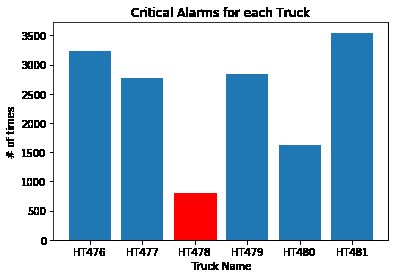

    Based on the number of critial alarms for each truck, it would suggest that truck 478 outperforms the other trucks. 

In [ ]:
TPrS = pd.read_csv('Production/TruckProductionSummary.csv')
equipNo = TPrS['EquipmentNumber']
Dict = set(equipNo)
DictList = list(Dict)
loadOfTrucks = TPrS['LoadTons']
TotalLoad = [0] * len(DictList)
for i in range (len(TotalLoad)):
    current_Truck = DictList.index(equipNo[i])
    TotalLoad[current_Truck] = TotalLoad[current_Truck] + loadOfTrucks[i]
    
minCritical = Truck.index(min(Truck))
barlist = plt.bar(DictList, TotalLoad)
barlist[minCritical].set_color('r')
plt.title('Total Load of each Truck (Tons)')
plt.ylabel('Load(tons)')
plt.xlabel('Truck Name')

del TPrS

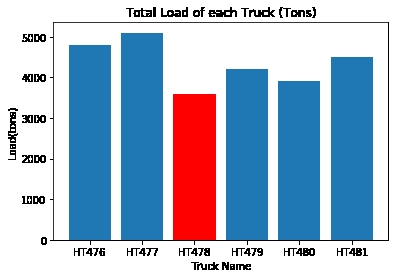

    The graph above also suggests that the truck that has to struggle the least in terms of hauling experiences less alarms and must breakdown less. However, when looking at the graph below of the number of breakdowns, the story changes.

In [ ]:
WO = pd.read_csv('/Maintenance/WorkOrders.csv')
probType = WO['PROBTYPE']
compID = WO['COMPID']
myDict = set(compID)
myDictList = list(myDict)
breakdownsNo = [0]*len(myDictList) # breakdownsNo is a list of number of breakdowns
for i in range (len(WO)):
    if probType[i] == 'Breakdown':
        current_Truck = myDictList.index(compID[i])
        breakdownsNo[current_Truck] += 1
        
maxBreakdowns = breakdownsNo.index(max(breakdownsNo))
        
barlist = plt.bar(myDictList, breakdownsNo)
barlist[maxBreakdowns].set_color('r')
plt.title('# of Breakdowns for each Truck')
plt.ylabel('# of times')
plt.xlabel('Truck Name')

del WO

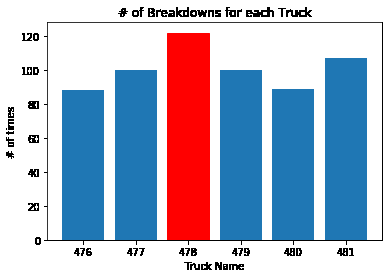

    Furthermore, If we consider the number of level 2 alarms associated with trucks, it starts to make the number of breakdowns associated with each truck make more sense. 

In [ ]:
NDR = pd.read_csv('/Maintenance/NotificationDetailsReport.csv')

equipValues = NDR['Level'] # filtering Level

equipName = NDR['EquipmentName'] # filtering Truck Names

myDict = set(equipName) # finding the name of Trucks

myDictList = list(myDict) # set to list
        
Alarm2 = [0]*len(myDictList) # Alarm2 is a list of number 2 alarms
for i in range (len(equipValues)):
    if equipValues[i] == 2:
        current_Truck = myDictList.index(equipName[i])
        Alarm2[current_Truck] += 1
        
maxAlarm2 = Alarm2.index(max(Alarm2))

barlist = plt.bar(myDictList, Alarm2)
barlist[maxAlarm2].set_color('r')
plt.title('Level 2 Alarms for each Truck')
plt.ylabel('# of times')
plt.xlabel('Truck Name')


del NDR

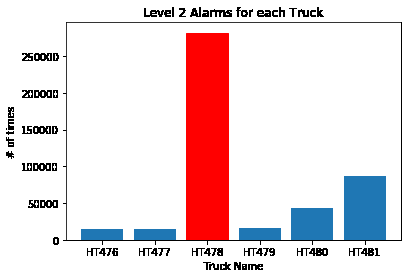

	Based on the graphs above, it may be indicative that trucks with higher level 2 alarms have a larger number of breakdowns. This may be indicative of a slow build-up in increasing level of warnings that may pre-empt an unscheduled breakdown.
    
GPS and Alarm Locations for Truck 478
    
    The GPS locations of these alarm events are also shown below in a heat map indicating a larger frequency of events with hotter colours.

In [ ]:
# Import and clean out the nan from the NotificationDetailsReport
notification_df = pd.read_csv('/Maintenance/NotificationDetailsReport.csv')
notification_df['GPSLocation'] = notification_df['GPSLocation'].astype(str)
notification_df = notification_df[~(notification_df['GPSLocation']=='nan')]

# Map the GPS data to Latitude and longitude
f = lambda x : x[:x.find(':')-1]
g = lambda y : y[y.find(':')+1:]
notification_df['Long'] = notification_df['GPSLocation'].apply(f)
notification_df['Lat'] = notification_df['GPSLocation'].apply(g)

notification_df['Long'] = pd.to_numeric(notification_df['Long']) * (0.00000360715054381839) - 117.234704527191
notification_df['Lat'] = pd.to_numeric(notification_df['Lat']) * (0.00000274396439452962) + 40.6886779177036 

# Pull a specific truck and alarm level, take the next 'big' data points starting at 'x' and plot this on a map
big = 1100

truck = 'HT476'
level = 1

x=0
test = notification_df[notification_df['EquipmentName'] == truck]
test = test[test['Level']==level]
test = test.iloc[x:x+big]

a = np.mean(test['Lat'])
b = np.mean(test['Long'])
m = folium.Map(location = [a, b], zoom_start = 13)

    # mark each alarm as a point
for index, row in test.iterrows():
    folium.CircleMarker([row['Lat'], row['Long']],
                        radius=.5).add_to(m)
# convert to (n, 2) nd-array format for heatmap
paths = test[['Lat', 'Long']].values
paths = paths.tolist()

# plot heatmap
m.add_child(plugins.HeatMap(paths, radius=10))
del notification_df,test
m

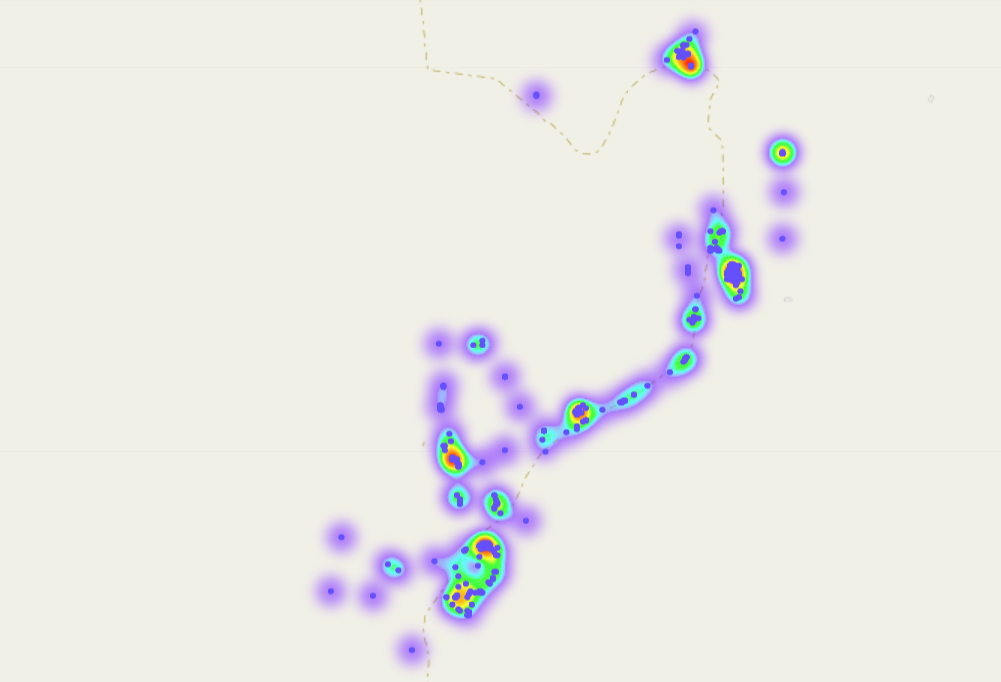

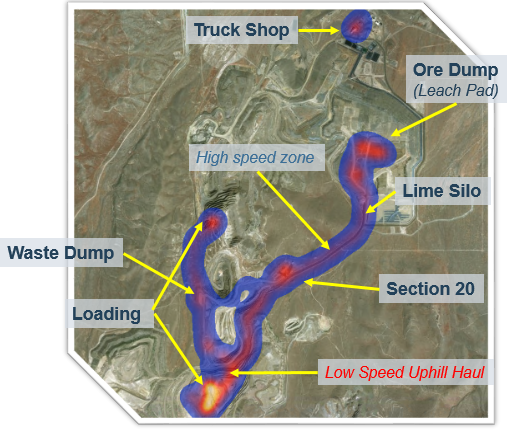

    As is evident from the graphs above, most alarms come from places the trucks spend most of their time: Ore Dump, Loading, Waste Dump, and the truck shop. The Low speed uphill Haul zone shows a significant bloom in activity as well maybe indicating that the trucks are under too much stress during the haul. 
    
Temperature and Pressure Profiles of Engine Parts
    
    Further consideration was given for the temperature and pressure profiles for all Hitachi truck 478 in the fleet to analyze any trends.

All graphs have a line that is an average the data for a day. The grey regions represent the variance on that average. These graphs were generated by R so the code is not shown.

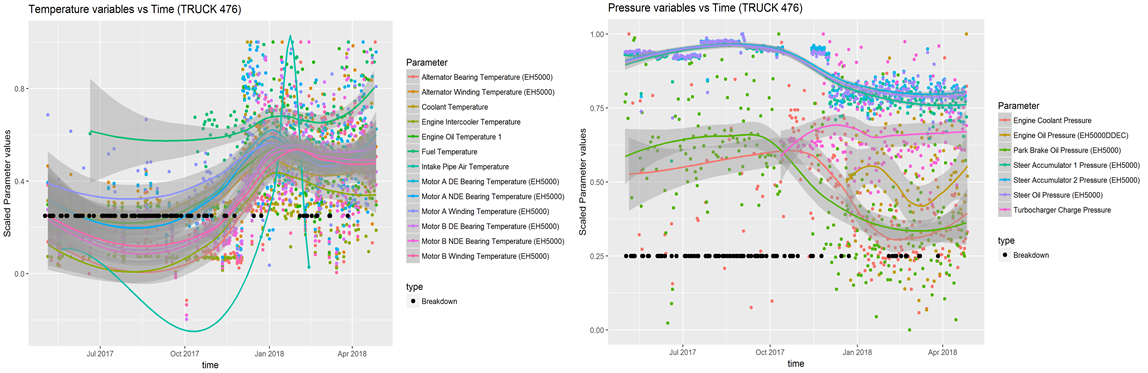

    All Temperature variables show an overall pattern of low operating temperature before November 2017 and higher operating temperature after that.
    Pressure variables show an opposite operating pattern than temperature. Higher before November 2017 and lower after that. 

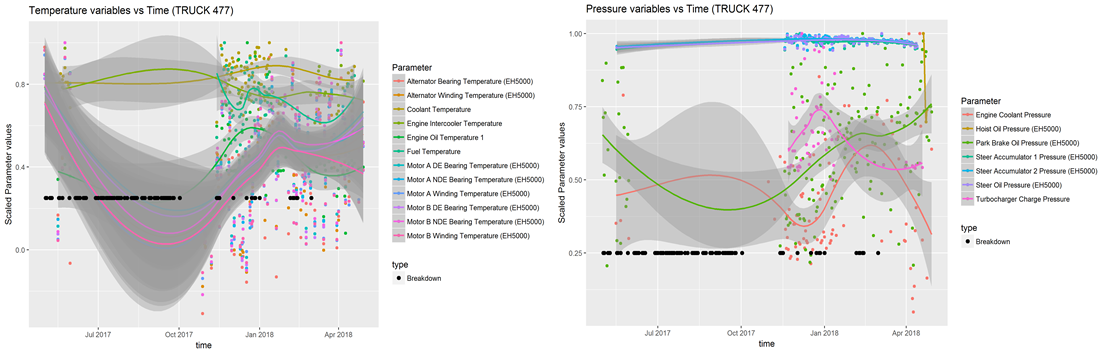

    Not enough data before November 2017
    
    No large variation in temperature of different component of the truck with time.
    
    Some components show variation of pressure with time 
    
    The black dots show the “breakdown” from work order

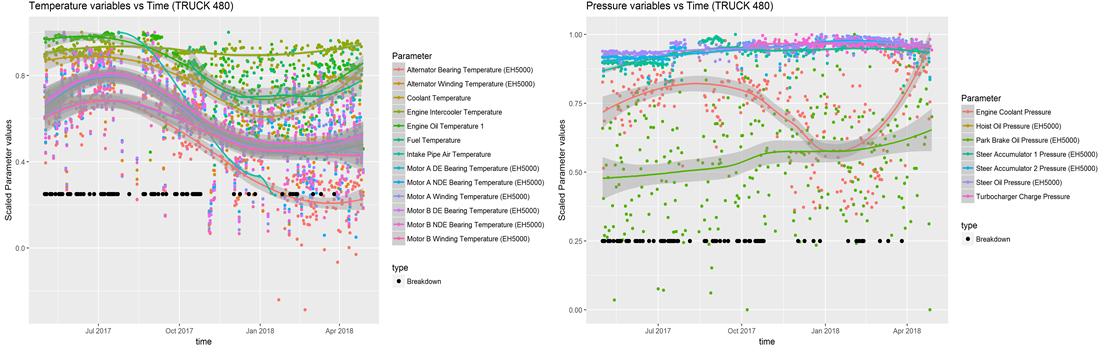

    All operating Temperature variables show an opposite time series parent compared to Truck 476. High operating temperature before November 2017 and low operating temperature after that.
    Except Engine coolant and park break pressure, all other variables do to show any significant change in pressure with time. 

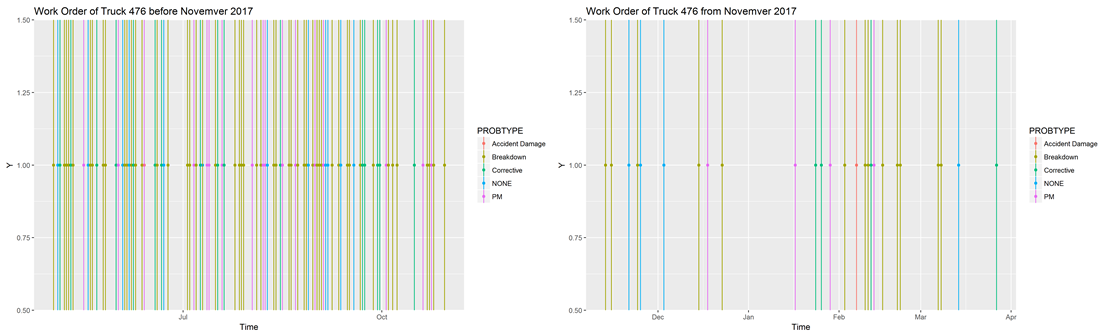

    A Work Order is a file that an employee submits for a repair and these are shown above plotted over the year for a single truck.
    There is more work order before November 2017 (around) and very few after that time period. This was found for all trucks within the fleet indicating a turnaround in maintenance issues. This was confirmed by SSR as the trucks started to go for regular maintenance more often.
    We also looked at failure events in terms of engine components:

In [ ]:
df1 = pd.read_csv('/Maintenance/WorkOrders.csv')
#Extract all data corresponding to truck 476
workOrder476 = df1[df1['COMPID']==476]
#24V MECHANICAL, HV ELECTRICAL, ENGINES, HYDRAULIC HOSES & FITTINGS, TIRES, CAB, SAFETY, RADIOS, FRAME AND BODY, STEERING SYSTEM, BRAKES,LUBRICANTS
breakDown476 = workOrder476[workOrder476['SCHEDULED']=='UNSCHEDULED']
mechanicalFailure = breakDown476[breakDown476['ACCTDESC']=='24V MECHANICAL']
print("total number of mechanical failure is %s" % (mechanicalFailure.shape[0]))
hydraulicFailure = breakDown476[breakDown476['ACCTDESC']=='HYDRAULIC HOSES & FITTINGS']
print("total number of HYDRAULIC HOSES & FITTINGS failure is %s" % (hydraulicFailure.shape[0]))
engineFailure = breakDown476[breakDown476['ACCTDESC']=='ENGINES']
print("total number of engine failure is %s" % (engineFailure.shape[0]))
electricalFailure = breakDown476[breakDown476['ACCTDESC']=='HV ELECTRICAL']
print("total number of electrical failure is %s" % (electricalFailure .shape[0]))
frameFailure = breakDown476[breakDown476['ACCTDESC']=='FRAME AND BODY']
print("total number of FRAME AND BODY failure is %s" % (frameFailure.shape[0]))
tireFailure = breakDown476[breakDown476['ACCTDESC']=='TIRES']
print("total number of tires failure is %s" % (tireFailure.shape[0]))
breaksFailure = breakDown476[breakDown476['ACCTDESC']=='BRAKES']
print("total number of Breaks failure is %s" % (breaksFailure.shape[0]))
steeringFailure = breakDown476[breakDown476['ACCTDESC']=='STEERING SYSTEM']
print("total number of STEERING SYSTEM failure is %s" % (steeringFailure.shape[0]))

del df1,breakDown476,mechanicalFailure,hydraulicFailure,engineFailure,electricalFailure,frameFailure,breaksFailure,steeringFailure

In [ ]:
total number of mechanical failure is 20
total number of HYDRAULIC HOSES & FITTINGS failure is 3
total number of engine failure is 10
total number of electrical failure is 2
total number of FRAME AND BODY failure is 6
total number of tires failure is 0
total number of Breaks failure is 5
total number of STEERING SYSTEM failure is 0

    We find that for truck 478, failures (unscheduled maintenance events) are primarily related to mechanical and engine failure events. This may link into the GPS data as most alarams were raised when the engines would have been in most use.

A Note on the Condition of the Data:

    Some of the parameters for each truck were very sparse as they were determined alarm events which were speradic at best. Some of the graphs below show this discrepency in the continuity of the data

In [ ]:
HT476_data_file = pd.read_csv("/Maintenance/TruckMachineData/TruckMachineData_HT476.csv")
pd.options.display.max_columns = 50

plt.style.use('seaborn')

parameters_label_col = HT476_data_file['Parameter']
parameters_value_col = HT476_data_file['ParameterValue']

# Get all the rows with paramater labels containing the word "Temperature"

rows_with_temperature = HT476_data_file[HT476_data_file['Parameter'].str.contains("Temperature")]

# Print each temperature item with time vs temperature

parameter_label_list = []

for parameter_label in rows_with_temperature['Parameter']:
    
    if(parameter_label not in parameter_label_list):
        
        parameter_label_list.append(parameter_label)

list(parameter_label_list)

# For each parameter label, we will save it's corresponding parameter values

import matplotlib.pyplot as plt
import numpy as np

# Seperate the relevant columns

temperature_labels_column = rows_with_temperature['Parameter']
temperature_values_column = rows_with_temperature['ParameterValue']

# Plot each temperature

def plot_temperatures():

    for label in parameter_label_list:

        current_temp_label = temperature_labels_column[temperature_labels_column == label]
        current_index = current_temp_label.index
        current_temp_value = temperature_values_column[current_index]
        
        plt.figure(figsize=(16,10))
        plt.plot(current_temp_value)
        plt.title(label)
        plt.show()
        
plot_temperatures()
        
for label in parameter_label_list:
    
    current_temp_label = temperature_labels_column[temperature_labels_column == label]
    current_index = current_temp_label.index
    current_temp_value = temperature_values_column[current_index]

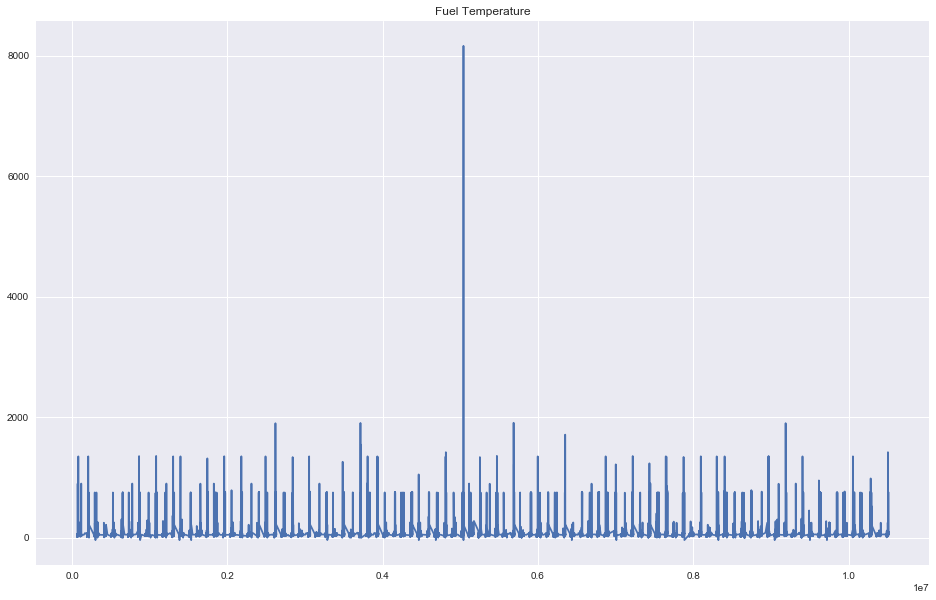

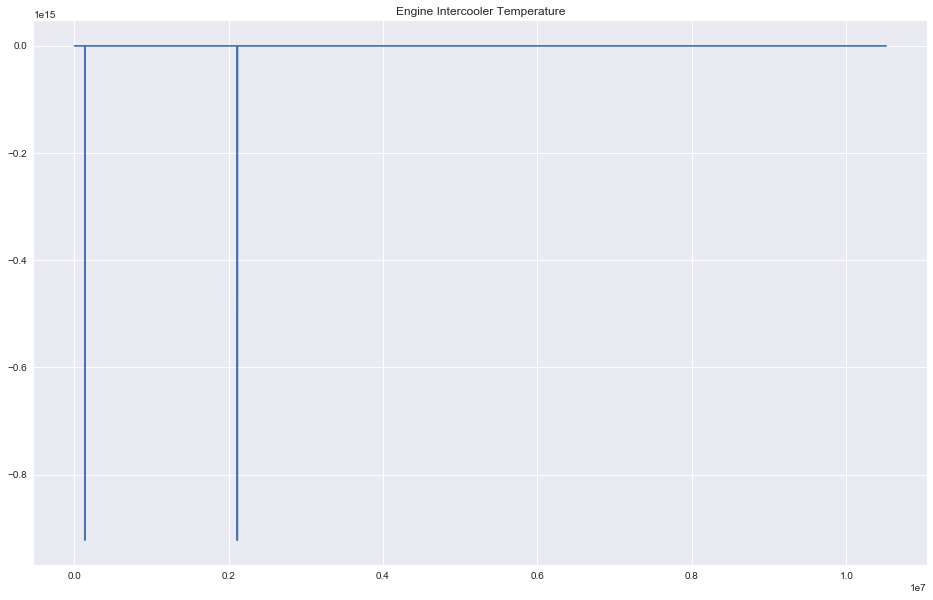

Correlation between Measured Parameters from Truck 478 Alarms

    Despite inevitable holes in the data, an attempt was made to smooth the data of outliers and make it more continuous for truck 478. This was done by averaging all data taken for one parameter in a day. Thus, we get a matrix where we have 365 rows (as we have averaged over each day), and 41 columns (as there are 41 different parameters that are measured). The matrix still had many NaN values, so columns that had more than a certain number where then filtered from the matrix. In this case, columns that had more than 260 NaN values were removed.  Then, the correlation matrix was produced below between the remaining parameters.

In [ ]:
TruckNumber = '478'
TruckHT = pd.read_csv('/Maintenance/TruckMachineData/TruckMachineData_HT'+str(TruckNumber)+'.csv')

pd.options.mode.chained_assignment = None #to suppress warnings
params = list(set(TruckHT['Parameter']))
count = 0
TruckParameters = pd.DataFrame()

#Average all parameters per day for truck 478

for parameter in params:
    TruckParameter = TruckHT[TruckHT['Parameter'] == parameter]
    TruckParameter = TruckParameter[['ParameterValue','ParameterReadTime1']]
    TruckParameter['ParameterReadTime1'] = pd.to_datetime(TruckParameter['ParameterReadTime1'])
    TruckParameter = TruckParameter.sort_values(by='ParameterReadTime1')
    TruckParameter = TruckParameter.set_index(['ParameterReadTime1'])
    TruckParameter = TruckParameter.resample('D').mean()
    if count == 0:
        TruckParameters['Date'] = TruckParameter.index
        TruckParameters = TruckParameters.set_index(['Date'])
    TruckParameters[parameter] = TruckParameter['ParameterValue']

    count += 1
    
listNew = TruckParameters.isna().sum()
list2 = []
max(listNew.index)
for i in range(len(listNew)):
    if (listNew[i] > 260):
        list2.append(listNew.index[i])  

        
NewMatrix = TruckParameters.drop(list2,axis=1)        
corel = NewMatrix.corr()
plt.figure(2)
plt.figure( figsize=(9,9) )

plt.imshow(corel, interpolation='nearest', cmap=plt.cm.ocean)

plt.colorbar()

plt.show()

The parameters are included below and the ones with a value greater than 260 are neglected.

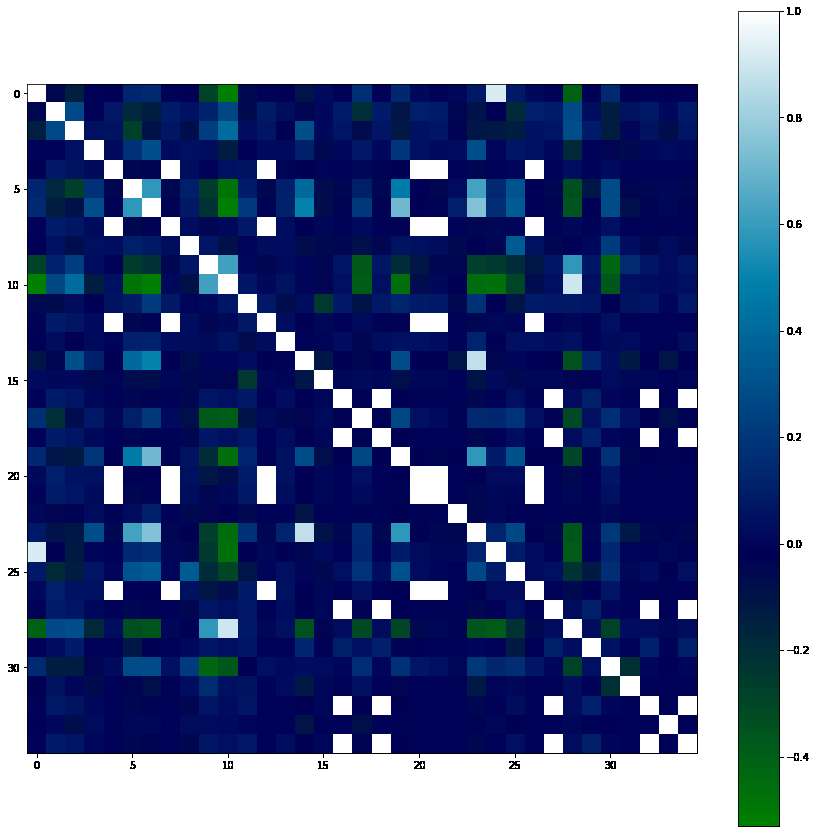

In [ ]:
Engine Intercooler Temperature                               160
Shift Lever Forward (EH5000)                                  45
Motor B DE Bearing Temperature (EH5000)                      169
Fuel Flow Rate                                               343
Steer Accumulator 2 Pressure (EH5000)                         42
Park Brake Oil Pressure (EH5000)                             115
Battery Power Voltage                                        150
Truck Speed (EH5000)                                          18
Turbocharger Charge Pressure                                 194
Payload Limit (EH5000)                                        23
Motor A DE Bearing Temperature (EH5000)                      169
Park Brake Press Switch (EH5000)                             115
Drive System Fault Number for Oper. (Shutdown) 7 (EH5000)    169
Fuel Level (EH5000)                                          258
Optimum Load Signal                                          357
Intake Pipe Air Temperature                                  354
Motor B Winding Temperature (EH5000)                         169
Throttle Percentage (EH5000)                                 186
Drive System Fault Number for Oper. (Warning) 6 (EH5000)     169
Alternator Winding Temperature (EH5000)                      169
Park Brake Solenoid Valve (EH5000)                           115
Body Angle (EH5000)                                           50
Static Payload (EH5000)                                      354
Engine Oil Pressure (EH5000DDEC)                             252
Service Brake Switch (EH5000)                                 79
Retard Percentage (EH5000)                                   186
Fuel Temperature                                             193
Alternator Bearing Temperature (EH5000)                      169
Engine Coolant Pressure                                      145
Engine Oil Temperature 1                                     144
Engine Speed                                                  20
Coolant Temperature                                          148
Activate External Preheating                                 235
Steer Accumulator 1 Pressure (EH5000)                         42
Shift Lever Reverse (EH5000)                                  45
Motor A Winding Temperature (EH5000)                         169
Motor A NDE Bearing Temperature (EH5000)                     169
Engine Oil Level (EH5000DDEC)                                252
Actual Rpm Request                                           357
Motor B NDE Bearing Temperature (EH5000)                     169
Steer Oil Pressure (EH5000)                                   42

Logistic Regression on Truck 478 Parameters and Unscheduled Breakdowns

    At this point, we considered predicting unscheduled maintenance events based on linear combinations of the values of the parameters and then taking the sigmoid function of that value.  In other words, preforming a logistic regression on the matrix constructed earlier. The labels for each entry of that matrix will be a zero (no unscheduled maintenance event that day) or a one (unscheduled maintenance event). Below, we construct these labels using the work orders issued for a day as a work order means an unscheduled maintenance event (which we have filtered for truck 478 and unscheduled work orders).

In [ ]:
# Set up for Logistic Regression Model (Y-values)
TruckNumber = 476
TruckWO = WorkOrder[WorkOrder['COMPID'] == TruckNumber]
TruckWORepairDates = TruckWO[(TruckWO['SCHEDULED'] == 'UNSCHEDULED')]
TruckWORepairDates = TruckWORepairDates[['DATE_WO','SCHEDULED']]
TruckWORepairDates['DATE_WO'] = pd.to_datetime(TruckWORepairDates['DATE_WO'])
TruckWORepairDates = TruckWORepairDates.set_index(['DATE_WO'])
ColO1 = np.ones(len(TruckWORepairDates))
TruckWORepairDates['Label'] = ColO1
TruckWORepairDates = TruckWORepairDates.resample('D').max()
TruckWORepairDates = TruckWORepairDates.drop('SCHEDULED', axis=1)
TruckWORepairDates = TruckWORepairDates.fillna(0)

dist = len(TruckParameters) - len(TruckWORepairDates)
axisVal = 1+np.arange(dist)
ZeroCol = np.zeros((dist))
base = TruckWORepairDates.index[-1]
dateArray = np.array([base + datetime.timedelta(days=np.float64(i)) for i in axisVal])
ColSer = pd.Series(ZeroCol,index=dateArray)
TruckWORepairDates = TruckWORepairDates['Label'].append(ColSer

    Some of the parameters on the X-matrix where removed to achieve a better fit of the data which was found experimentally to be about 13 useful parameters. These also happened to be the most continuous parameters that the systems measuring them were able to give. 

In [ ]:
# Logistic Regression
imputer = Imputer()

listNew = TruckParameters.isna().sum()
list2 = []
for i in range(len(listNew)):
    if (listNew[i] > 130):
        list2.append(listNew.index[i])
        
TruckParametersClean = TruckParameters.drop(list2,axis=1) 

AccuarcyMatrix = []

for i in range(20):
    X = TruckParametersClean.values
    Y = TruckWORepairDates.values
    m,n = X.shape
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, Y = X[shuffle], Y[shuffle]
    X = imputer.fit_transform(X)

    X_train, Y_train = X[:int(m*0.6)], Y[:int(m*0.6)]
    X_test, Y_test = X[int(m*0.6):], Y[int(m*0.6):]

    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
    X_train_scaled_d2 = poly.fit_transform(X_train_scaled)
    X_test_scaled_d2 = poly.fit_transform(X_test_scaled)

    # Split into train and test.


    #Actual model
    lr = LogisticRegression()
    lr.fit(X_train_scaled_d2, Y_train)
    preds = lr.predict(X_test_scaled_d2)
    accuracy = np.mean(preds == Y_test)
    AccuracyMatrix.append(accuracy)
    #print("Accuracy is: ", accuracy)

meanAcc = np.mean(AccuracyMatrix)

    The code above was ran 20 times, with the y labels and X-matrix shuffled, and with a training size that is 60% of the data and a test set that is 40% of the data for 1 truck. The accuracy of this model was found to be 74.45%. 
    
Failure of the Logistic Regression Model and Future Work:

    The failing of the model comes from the fact that for the entire data set for this truck, unscheduled maintenance events only make up 22%. Therefore, If the model has simply guessed all zero labels, it would have a 78% success rate for this data set outperforming the actual regression. This may be due to the incompleteness of the data (many Nan values) or the fact that the model doesn’t really account for the fact that it is a time series. Logistic regression assumes that the data is independently and identically distributed but for a time series this is not necessarily true.
    Future areas of interest can consider the potential clustering of these alarms between different parameters and finding out where failure zones are. Another area of consideration is in the lead up to an unscheduled maintenance event in the time series data. The models we considered did not really take these into account. The concepts talked about here are illustrated below.

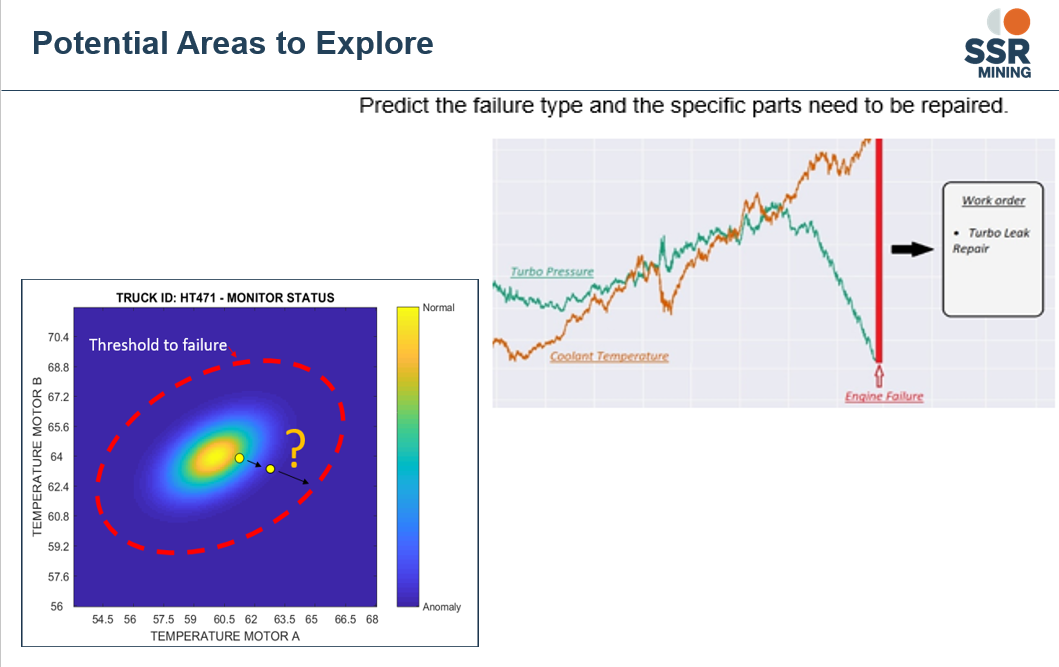

    Other considerations are based on the fact that there are negative and positive correlations between different parameters as shown by the correlation matrix, principal component analysis could be used as a dimensionality reduction tactic. It can also show the contrasts between which parameters are more important for explaining the variation of the data. This process is shown below.

Note: the below scenarios are using toy data and not that from SSR

In [ ]:
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import seaborn as sb
%matplotlib inline
loan = pd.read_csv('/loan.csv').sample(frac = .25) #read the dataset and sample 25% of it
len(loan.columns)
#Data Wrangling
loan.replace([np.inf, -np.inf], np.nan) #convert infs to nans
loan = loan.dropna(axis = 1, how = 'any') #remove nans
loan = loan._get_numeric_data() #keep only numeric features
x = loan.values #convert the data into a numpy array
x = scale(x);x
covar_matrix = PCA(n_components = 20) 
covar_matrix.fit(x)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

del loan

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features
plt.figure(figsize = (8,8))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

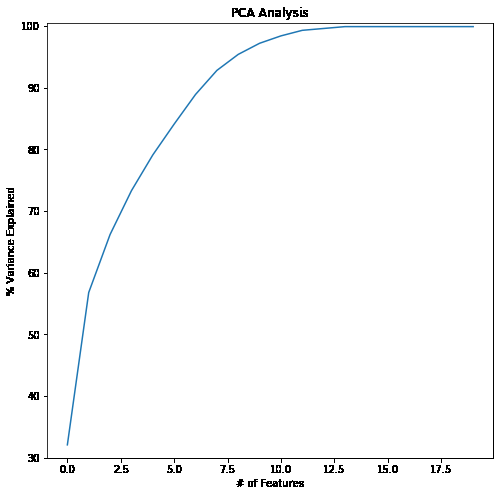

    For example, 90% of the variance in the data can be explained by around 8 features or prameters. Now if this is true for certain data, we could construct a smaller space based on the components found by the above process.

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])
from sklearn.preprocessing import StandardScaler
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['target']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
pca.explained_variance_ratio_
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.grid()

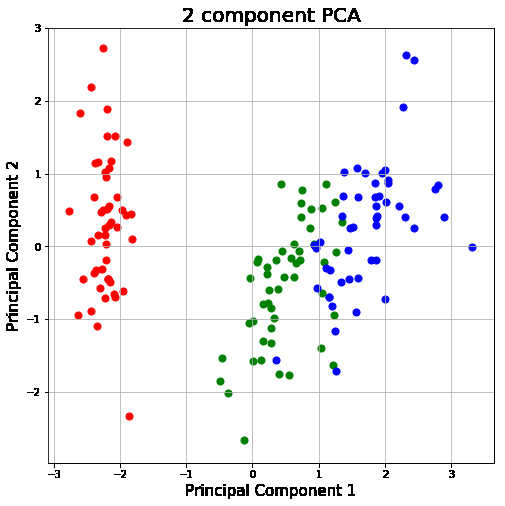

    Thanks very much for reading and to the wonderful mentors at SSR!